In [1]:
"""
This module computes results for transfer learning

>>>python graph_laplacian.py setting case static_use source target random_seed train_percentage
setting: transfer or normal
case: 1, 2, 3, 4; 2 is for our proposed approach, 4 is for standard TF
static_use: "True" or "False"- If False, we don't use static household properties 
and the corresponding laplacian penalty term is set to 0
constant_use: "True" or "False" - If True, we add the constraint that one column of seasonal factors to be 1.
source:
target:
random_seed:
train_percentage:

NB: Prediction region is always called target. So, if we are doing n
normal learning on SD, we don't care about source, but target will be SD

Example:
# Transfer learning from Austin -> SD, case 2, 10% data used, 0th random seed, static_data used
>>> python graph_laplacian.py transfer 2 True Austin SanDiego 0 10

# Normal training in SD, case 2, 10% data used, 0th random seed, static data used
>>> python graph_laplacian.py normal 2 True None SanDiego 0 10

TODO: mention the objective being solved here

"""
import matplotlib.pyplot as plt
%matplotlib inline
import datetime


from sklearn.model_selection import train_test_split, KFold

from common import compute_rmse_fraction, contri, get_tensor, create_region_df_dfc_static
from create_matrix import *
from tensor_custom_core import *

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014

source = 'Austin'
target = 'SanDiego'
source_df, source_dfc, source_tensor, source_static = create_region_df_dfc_static(source, year)
target_df, target_dfc, target_tensor, target_static = create_region_df_dfc_static(target, year)

# # using cosine similarity to compute L
source_L = get_L(source_static)
target_L = get_L(target_static)

pred = {}
n_splits = 10

for appliance in APPLIANCES_ORDER:
	pred[appliance] = []
best_params_global = {}
kf = KFold(n_splits=n_splits)

In [4]:
case = 4
num_home_factors = 3
num_season_factors = 3
num_iterations = 2000
learning_rate = 0.1
lam = 0.001
T_constant = np.ones(12).reshape(-1,1)

In [5]:
case = 4
H_source_4, A_source_4, T_source_4, Hs_source_4, As_source_4, Ts_source_4, HATs_source_4, costs_source_4 = learn_HAT_adagrad_graph(case, source_tensor,
                                                                                          source_L,
                                                                                          num_home_factors,
                                                                                          num_season_factors,
                                                                                          num_iter=num_iterations,
                                                                                          lr=learning_rate, dis=False,
                                                                                          lam=lam,
                                                                                          T_known=T_constant)

In [6]:
case = 2
H_source_2, A_source_2, T_source_2, Hs_source_2, As_source_2, Ts_source_2, HATs_source_2, costs_source_2 = learn_HAT_adagrad_graph(case, source_tensor,
                                                                                          source_L,
                                                                                          num_home_factors,
                                                                                          num_season_factors,
                                                                                          num_iter=num_iterations,
                                                                                          lr=learning_rate, dis=False,
                                                                                          lam=lam,
                                                                                          T_known=T_constant)

In [7]:
HAT_2 = multiply_case(H_source_2, A_source_2, T_source_2, 2)
pred_2 = {}

for appliance_name, appliance_id in appliance_index.iteritems():
    pred_2[appliance_name] = []
    pred_2[appliance_name].append(pd.DataFrame(HAT_2[:,appliance_id,:], index=source_df.index))

In [8]:
HAT_4 = multiply_case(H_source_4, A_source_4, T_source_4, 4)
pred_4 = {}

for appliance_name, appliance_id in appliance_index.iteritems():
    pred_4[appliance_name] = []
    pred_4[appliance_name].append(pd.DataFrame(HAT_4[:,appliance_id,:], index=source_df.index))

In [9]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse
from common import compute_rmse_fraction
out_2 = {}
out_4 = {}

for appliance in APPLIANCES_ORDER[1:]:
    out_2[appliance] = {}
    out_4[appliance] = {}
    s_2 = pd.concat(pred_2[appliance]).ix[source_df.index]
    s_4 = pd.concat(pred_4[appliance]).ix[source_df.index]
    if appliance=="hvac":
        out_2[appliance] = compute_rmse_fraction(appliance,s_2[range(4, 10)],'Austin')[2]
        out_4[appliance] = compute_rmse_fraction(appliance,s_4[range(4, 10)],'Austin')[2]
    else:   
        out_2[appliance] = compute_rmse_fraction(appliance, s_2,'Austin')[2]
        out_4[appliance] = compute_rmse_fraction(appliance, s_4,'Austin')[2]

/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [10]:
out_2

{'dw': 1.2674632447426291,
 'fridge': 4.6160320728274362,
 'hvac': 14.905296414190024,
 'mw': 1.5697334288916986,
 'oven': 1.4941288125962218,
 'wm': 0.60210532724837063}

In [11]:
out_4

{'dw': 1.2960631053662317,
 'fridge': 4.5943129907873637,
 'hvac': 18.513076613256167,
 'mw': 1.4093965181574701,
 'oven': 1.5607837529876694,
 'wm': 0.57784881512697739}

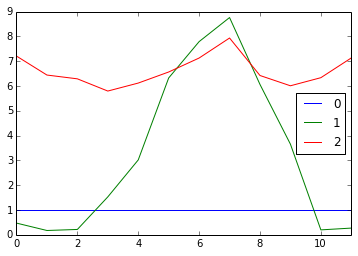

In [12]:
pd.DataFrame(T_source_2).plot()

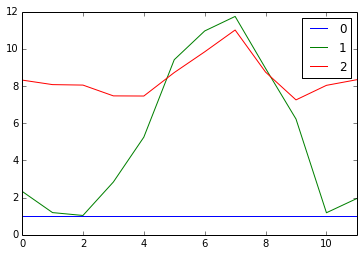

In [13]:
pd.DataFrame(T_source_4).plot()